## Predict Movie Revenue Using Linear Regression

### Can we predict a movie's box office revenue based on its production budget?

In [298]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.autograd import Variable

### Data Prep -- Create Clean CSV

In [299]:
dirty_csv_path = "dirty_data.csv"
df = pd.read_csv(dirty_csv_path)
df.drop(columns=['Rank', 'Release Date', 'Movie Title', 'Domestic Gross ($)'], inplace=True)
df.columns.values[0] = 'production_budget'
df.columns.values[1] = 'worldwide_gross'


def df_cleanup(df):
    for column in df.columns:
        for i in range(0, df.index.stop):
            temp_array = []
            for j in df.at[i,column]:
                if j == '$' or j == ',':
                    continue
                temp_array.append(j)
            df.at[i, column] = int("".join(temp_array))
            
    zeros = []
    for i in range(0, df.index.stop):
        if df.at[i, 'worldwide_gross'] == 0:
            zeros.append(df.index[i])
    
    
    df.drop(index=zeros, inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns="index", inplace=True)
    df.to_csv("clean_data.csv")
    return df



df_cleanup(df)

,production_budget,worldwide_gross
0,110000,11000000
1,200000,8000000
2,100000,3000000
3,245000,22000000
4,3900000,9000000
...,...,...
5029,55000000,376856949
5030,40000000,166893990
5031,185000000,561137727
5032,175000000,140012608


### Import Clean CSV

In [300]:
clean_csv_path = "clean_data.csv"
df2 = pd.read_csv(clean_csv_path)
df2.drop(columns='Unnamed: 0', inplace=True)
df2
# df2.describe()

,production_budget,worldwide_gross
0,110000,11000000
1,200000,8000000
2,100000,3000000
3,245000,22000000
4,3900000,9000000
...,...,...
5029,55000000,376856949
5030,40000000,166893990
5031,185000000,561137727
5032,175000000,140012608


In [301]:
x = pd.DataFrame(df['production_budget'])
y = pd.DataFrame(df['worldwide_gross'])

x_train, x_test, y_train, y_test = train_test_split(x,y)

x_train = np.array(x_train.values, dtype=np.float32).reshape(-1, 1)
x_test = np.array(x_test.values, dtype=np.float32).reshape(-1, 1)
y_train = np.array(y_train.values, dtype=np.float32).reshape(-1, 1)
y_test = np.array(y_test.values, dtype=np.float32).reshape(-1, 1)


# Normalization (Min-Max)
from sklearn.preprocessing import MinMaxScaler
mmscale=MinMaxScaler()
#x_train = mmscale.fit_transform(x_train)
#y_train = mmscale.fit_transform(x_train)


from sklearn.preprocessing import StandardScaler
scalingstd = StandardScaler()
x_train = scalingstd.fit_transform(x_train)
x_test = scalingstd.fit_transform(x_test)
y_train = scalingstd.fit_transform(y_train)
y_test = scalingstd.fit_transform(y_test)

# Pytorch Neural Network Version

In [302]:
# Model Architecture -- Simple Linear Neuron
# Inherit from torch.nn.Module
# A fully connected layer, one input --- one output  
# The layer (technically input/weight combo). A weight 
# is applied to an input; output is Ax+b ([weight*input] + bias) 
# Entirely Linear so no activation function
# Only need to define how the input signal is processed
# Just specify how the neuron layer modifies its input signal
class LinearRegressionModel(nn.Module): 
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    def forward(self, x):
        y_hat = self.linear(x)
        return y_hat

In [303]:
# 1 Input -- 1 Output
input_dim = 1
output_dim = 1
learning_rate = 0.001
epochs = 1000

model = LinearRegressionModel(input_dim, output_dim)
##### FOR GPU ######
if torch.cuda.is_available():
    model.cuda()
    
# Loss Function: Mean Squared Error
criterion = nn.MSELoss()

# Optimization: Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [304]:
# Training 
params = []
for epoch in range(epochs):
    # Converting inputs and labels to variable 
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else: 
        print('GPU Not Available!')

    # Clear gradient buffers. 
    # Gradients from previous epoch not needed.
    # Don't want to cummulate gradients.
    optimizer.zero_grad()

    # Get output from model, given the inputs 
    y_hat = model(inputs)    
    
    # Get loss for the predicted output 
    loss = criterion(y_hat, labels)

    # Get gradients w.r.t the parameters 
    loss.backward()
    params.append(torch.nn.utils.parameters_to_vector(model.parameters()).data)
    # update parameters 
    optimizer.step()
    
    print(f'epoch {epoch}, loss{loss.item()}')

epoch 0, loss4.184129238128662
epoch 1, loss4.169177532196045
epoch 2, loss4.1542863845825195
epoch 3, loss4.139454364776611
epoch 4, loss4.12468147277832
epoch 5, loss4.1099677085876465
epoch 6, loss4.095312595367432
epoch 7, loss4.080716609954834
epoch 8, loss4.066178321838379
epoch 9, loss4.051697731018066
epoch 10, loss4.037276268005371
epoch 11, loss4.022911548614502
epoch 12, loss4.008604526519775
epoch 13, loss3.994354724884033
epoch 14, loss3.980161666870117
epoch 15, loss3.9660253524780273
epoch 16, loss3.9519450664520264
epoch 17, loss3.9379217624664307
epoch 18, loss3.923954486846924
epoch 19, loss3.9100427627563477
epoch 20, loss3.896186590194702
epoch 21, loss3.8823859691619873
epoch 22, loss3.868640661239624
epoch 23, loss3.854950189590454
epoch 24, loss3.8413140773773193
epoch 25, loss3.827732563018799
epoch 26, loss3.8142054080963135
epoch 27, loss3.800732374191284
epoch 28, loss3.7873129844665527
epoch 29, loss3.7739474773406982
epoch 30, loss3.7606351375579834
epoch 3

epoch 410, loss1.167152762413025
epoch 411, loss1.164257287979126
epoch 412, loss1.1613733768463135
epoch 413, loss1.1585010290145874
epoch 414, loss1.1556400060653687
epoch 415, loss1.1527905464172363
epoch 416, loss1.1499526500701904
epoch 417, loss1.1471256017684937
epoch 418, loss1.1443102359771729
epoch 419, loss1.1415060758590698
epoch 420, loss1.138713002204895
epoch 421, loss1.1359310150146484
epoch 422, loss1.1331603527069092
epoch 423, loss1.1304006576538086
epoch 424, loss1.1276520490646362
epoch 425, loss1.124914288520813
epoch 426, loss1.1221877336502075
epoch 427, loss1.119471788406372
epoch 428, loss1.1167668104171753
epoch 429, loss1.1140726804733276
epoch 430, loss1.1113892793655396
epoch 431, loss1.108716607093811
epoch 432, loss1.106054663658142
epoch 433, loss1.1034033298492432
epoch 434, loss1.1007624864578247
epoch 435, loss1.0981323719024658
epoch 436, loss1.0955126285552979
epoch 437, loss1.0929033756256104
epoch 438, loss1.0903043746948242
epoch 439, loss1.0877

epoch 849, loss0.5674958229064941
epoch 850, loss0.5669966340065002
epoch 851, loss0.5664993524551392
epoch 852, loss0.5660040378570557
epoch 853, loss0.5655107498168945
epoch 854, loss0.5650193691253662
epoch 855, loss0.5645300149917603
epoch 856, loss0.5640426874160767
epoch 857, loss0.5635570883750916
epoch 858, loss0.5630735754966736
epoch 859, loss0.5625920295715332
epoch 860, loss0.5621123313903809
epoch 861, loss0.5616345405578613
epoch 862, loss0.5611586570739746
epoch 863, loss0.5606847405433655
epoch 864, loss0.5602126717567444
epoch 865, loss0.5597425103187561
epoch 866, loss0.5592741966247559
epoch 867, loss0.5588077902793884
epoch 868, loss0.5583431720733643
epoch 869, loss0.5578805208206177
epoch 870, loss0.5574197173118591
epoch 871, loss0.5569606423377991
epoch 872, loss0.5565034747123718
epoch 873, loss0.5560481548309326
epoch 874, loss0.5555945634841919
epoch 875, loss0.555142879486084
epoch 876, loss0.5546929836273193
epoch 877, loss0.554244875907898
epoch 878, loss0

In [305]:
torch.nn.utils.parameters_to_vector(model.parameters()).data

tensor([0.5173, 0.1252], device='cuda:0')

[[ 0.5305618 ]
 [-0.3100433 ]
 [ 0.88009405]
 ...
 [-0.31336588]
 [ 2.0097609 ]
 [-0.2628631 ]]


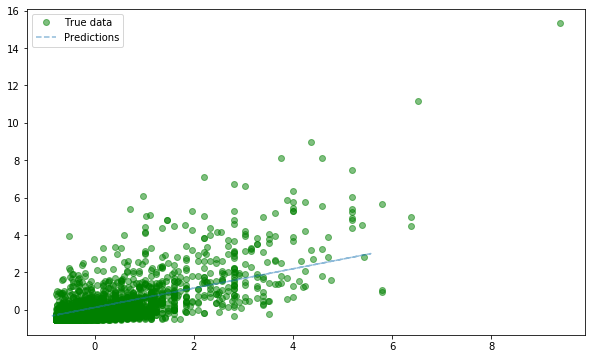

In [306]:
# Testing 
with torch.no_grad(): # Gradients not needed in testing phase.
    test_input = Variable(torch.from_numpy(x_test))
    if torch.cuda.is_available():
        predicted = model(test_input.cuda()).cpu().data.numpy()
    else:
        predicted = model(test_input).data.numpy()
    print(predicted)

plt.figure(figsize=[10,6])
plt.clf()
plt.plot(x_train, y_train, 'go', label='True data', alpha=0.5)
plt.plot(x_test, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()

In [307]:
list(model.parameters())

[Parameter containing:
 tensor([[0.5173]], device='cuda:0', requires_grad=True), Parameter containing:
 tensor([0.1252], device='cuda:0', requires_grad=True)]

In [308]:
x_sample = scalingstd.fit_transform([[11000000]])

In [309]:
yout = 36000 * 0.5977 + 0.0145

In [310]:
yout

21517.214500000002